# Model Training & Evaluation Pipeline

Details: [Model Training Specifications](https://docs.google.com/document/d/1UiDi8nyTcfMeMNIAz3KntlVZBlYrpoMAURuDccTt-wk/edit?usp=sharing)

Model Evaluation: Identify best parameters for each model

In [ ]:
# Basic Libraries

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data Source

df = pd.read_csv("/content/drive/MyDrive/cleaned_gee_data.csv")
df = df.drop(columns = ['Unnamed: 0', 'BRIGHTNESS'], axis=1) # Brightness not available in sensor device
df.head() 

,LATITUDE,LONGITUDE,ACQ_DATE,ACQ_TIME,OPEN_TIME,CLOSE_TIME,FIRE_OCCURRED,CO_MOL/M2,SO2_MOL/M2,NO2_MOL/M2,O3_MOL/M2,LOCATION,INSTRUMENT,DRY_SEASON
0,-5.466232,-0.176027,-1.866392,0.634294,0.506405,0.526945,0,-0.024223,-0.474440,-1.152277,-0.511001,-1.159086,0,1
1,-5.466232,-0.176027,-1.866392,0.634294,0.506405,0.526945,0,0.113599,-0.474440,-1.152277,-0.511001,-1.159086,0,1
2,-5.466232,-0.176027,-1.866392,0.634294,0.506405,0.526945,0,-0.024223,-0.474440,-1.361255,-0.511001,-1.159086,0,1
3,-5.466232,-0.176027,-1.866392,0.634294,0.506405,0.526945,0,0.113599,-0.474440,-1.361255,-0.511001,-1.159086,0,1
4,-5.433352,-0.197441,-1.723773,0.634294,2.286080,1.793843,0,-0.967684,0.339667,-1.251770,0.426114,-1.159086,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171893 entries, 0 to 171892
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   LATITUDE       171893 non-null  float64
 1   LONGITUDE      171893 non-null  float64
 2   ACQ_DATE       171893 non-null  float64
 3   ACQ_TIME       171893 non-null  float64
 4   OPEN_TIME      171893 non-null  float64
 5   CLOSE_TIME     171893 non-null  float64
 6   FIRE_OCCURRED  171893 non-null  int64  
 7   CO_MOL/M2      171893 non-null  float64
 8   SO2_MOL/M2     171893 non-null  float64
 9   NO2_MOL/M2     171893 non-null  float64
 10  O3_MOL/M2      171893 non-null  float64
 11  LOCATION       171893 non-null  float64
 12  INSTRUMENT     171893 non-null  int64  
 13  DRY_SEASON     171893 non-null  int64  
dtypes: float64(11), int64(3)
memory usage: 18.4 MB


In [ ]:
display(df['FIRE_OCCURRED'].value_counts())

0    170544
1      1349
Name: FIRE_OCCURRED, dtype: int64

0.785% of FIRE_OCCURRED = 1

In [ ]:
X = df.drop('FIRE_OCCURRED', axis=1)
y = df['FIRE_OCCURRED']

In [ ]:
# Training, Validation, Testing Split

from sklearn.model_selection import train_test_split

# 80:10:10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=10, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=10, shuffle=True)

Original = [X_train, X_val, X_test, y_train, y_val, y_test] # For reference

In [ ]:
if len(X_train)==len(y_train) and len(X_test) == len(y_test) and len(X_val) == len(y_val):
  print("X and y data length matching")
else:
  print("Error in data preparation pipeline")
print()
print("No. of training data = %d" % len(X_train))
print("No. of validation data = %d" % len(X_val))
print("No. of testing data = %d" % len(X_test))

X and y data length matching

No. of training data = 137513
No. of validation data = 17190
No. of testing data = 17190


In [ ]:
display(y_val.value_counts())

0    17068
1      122
Name: FIRE_OCCURRED, dtype: int64

In [ ]:
display(y_test.value_counts())

0    17059
1      131
Name: FIRE_OCCURRED, dtype: int64

In [ ]:
# SMOTE

from collections import Counter
from imblearn.over_sampling import SMOTE 

print('Original dataset shape %s' % Counter(y_train))
sm = SMOTE(random_state=10)
X_train, y_train = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 136417, 1: 1096})
Resampled dataset shape Counter({0: 136417, 1: 136417})


In [ ]:
# Shuffle Data since SMOTE appended many 1s at the end
# Required for some algorithms such as ANN

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state = 10)

In [ ]:
# Evaluation Metrics

from sklearn.metrics import confusion_matrix, recall_score, f1_score, roc_auc_score, accuracy_score

def evaluation_metrics(y_true, y_pred):
  cfm = confusion_matrix(y_true, y_pred).ravel()
  acc = accuracy_score(y_true, y_pred)
  recs = recall_score(y_true, y_pred, average='binary')
  f1s = f1_score(y_true, y_pred, average='binary')
  rocs = roc_auc_score(y_true, y_pred, average='macro')
  return [cfm, acc, recs, f1s, rocs]

Confusion matrix format : [ tn , fp , fn , tp ]

In [ ]:
# Store Model Parameters and Eval

models = pd.DataFrame(columns = ['model_name', 'model', 'parameters'])
models_eval = pd.DataFrame(columns = ['model_name', 'confusion_matrix', 'accuracy', 'recall', 'f1_score', 'roc_auc_score'])

In [ ]:
# Import ML Algorithms

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import VotingClassifier

# RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

# Save Model

import pickle

## Logistic Regression

- Library: Scikit-learn

In [ ]:
# Training

name = 'log_clf'

train = pd.DataFrame(columns = ['penalty', 'warm_start', 'solver', 'max_iter', 'dual', 'n_jobs','random_state'])
train = train.append({'penalty' : 'none', 'warm_start': False, 'solver': 'newton-cg',  'max_iter': 247,  'dual': False, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)
train = train.append({'penalty' : 'l2', 'warm_start': False, 'solver': 'newton-cg',  'max_iter': 100,  'dual': False, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    log_clf = LogisticRegression(penalty = row['penalty'], n_jobs = int(row['n_jobs']), random_state = int(row['random_state']))
    log_clf.fit(X_train, y_train)
   
    y_true = y_val
    y_pred = log_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': log_clf, 
                            'parameters': log_clf.get_params()}, 
                            ignore_index=True)
   
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,log_clf0,"[14046, 3022, 42, 80]",0.821757,0.655738,0.049628,0.739341
1,log_clf1,"[14044, 3024, 42, 80]",0.821640,0.655738,0.049597,0.739282


In [ ]:
# RandomizedSearchCV

random_grid = {
                "penalty": ['l1', 'l2', 'elasticnet', 'none'],
                "dual": [True, False],
                "max_iter" : [int(x) for x in np.linspace(100, 500, num = 20)],
                "warm_start" : [True, False],
                "solver" : ['lbfgs', 'newton-cg', 'liblinear'],
                "C" : [int(x) for x in np.linspace(0, 1, num = 50)]
              }

log_random = RandomizedSearchCV(estimator = log_clf, 
                                param_distributions = random_grid, 
                                n_iter = 70, 
                                cv = 3, 
                                verbose = 2, 
                                scoring = 'recall',
                                random_state = 10)

log_random.fit(X_train, y_train)
log_random.best_params_

Fitting 3 folds for each of 70 candidates, totalling 210 fits
[CV] END C=0, dual=True, max_iter=436, penalty=l2, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=436, penalty=l2, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=436, penalty=l2, solver=newton-cg, warm_start=False; total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV] END C=0, dual=False, max_iter=289, penalty=l1, solver=liblinear, warm_start=False; total time=   0.1s
[CV] END C=0, dual=False, max_iter=289, penalty=l1, solver=liblinear, warm_start=False; total time=   0.1s
[CV] END C=0, dual=False, max_iter=289, penalty=l1, solver=liblinear, warm_start=False; total time=   0.1s
[CV] END C=0, dual=True, max_iter=436, penalty=elasticnet, solver=newton-cg, warm_start=False; total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV] END C=0, dual=True, max_iter=436, penalty=elasticnet, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=436, penalty=elasticnet, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=247, penalty=l2, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=247, penalty=l2, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=247, penalty=l2, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0, dual=False, max_iter=289, penalty=l1, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0, dual=False, max_iter=289, penalty=l1, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0, dual=False, max_iter=289, penalty=l1, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0, dual=False, max_iter=310, penalty=elasticnet, solver=lbfgs, warm_start=True; total time=   0.0s
[CV] END C=0, dual=Fals

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=247, penalty=none, solver=newton-cg, warm_start=False; total time=   5.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=247, penalty=none, solver=newton-cg, warm_start=False; total time=   5.6s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=247, penalty=none, solver=newton-cg, warm_start=False; total time=   8.6s
[CV] END C=0, dual=False, max_iter=436, penalty=elasticnet, solver=liblinear, warm_start=False; total time=   0.0s
[CV] END C=0, dual=False, max_iter=436, penalty=elasticnet, solver=liblinear, warm_start=False; total time=   0.0s
[CV] END C=0, dual=False, max_iter=436, penalty=elasticnet, solver=liblinear, warm_start=False; total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=331, penalty=none, solver=lbfgs, warm_start=True; total time=   2.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=331, penalty=none, solver=lbfgs, warm_start=True; total time=   2.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=331, penalty=none, solver=lbfgs, warm_start=True; total time=   2.4s
[CV] END C=0, dual=False, max_iter=184, penalty=l2, solver=newton-cg, warm_start=True; total time=   0.1s
[CV] END C=0, dual=False, max_iter=184, penalty=l2, solver=newton-cg, warm_start=True; total time=   0.8s
[CV] END C=0, dual=False, max_iter=184, penalty=l2, solver=newton-cg, warm_start=True; total time=   0.8s
[CV] END C=0, dual=False, max_iter=247, penalty=l1, solver=lbfgs, warm_start=False; total time=   0.0s
[CV] END C=0, dual=False, max_iter=247, penalty=l1, solver=lbfgs, warm_start=False; total time=   0.0s
[CV] END C=0, dual=False, max_iter=247, penalty=l1, solver=lbfgs, warm_start=False; total time=   0.0s
[CV] END C=0, dual=False, max_iter=100, penalty=l2, solver=liblinear, warm_start=True; total time=   0.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV] END C=0, dual=False, max_iter=100, penalty=l2, solver=liblinear, warm_start=True; total time=   0.1s
[CV] END C=0, dual=False, max_iter=100, penalty=l2, solver=liblinear, warm_start=True; total time=   0.1s
[CV] END C=0, dual=False, max_iter=436, penalty=l2, solver=newton-cg, warm_start=True; total time=   0.8s
[CV] END C=0, dual=False, max_iter=436, penalty=l2, solver=newton-cg, warm_start=True; total time=   0.8s
[CV] END C=0, dual=False, max_iter=436, penalty=l2, solver=newton-cg, warm_start=True; total time=   0.8s
[CV] END C=0, dual=True, max_iter=247, penalty=elasticnet, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=247, penalty=elasticnet, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=247, penalty=elasticnet, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=1, dual=True, max_iter=478, penalty=l1, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=1, dual=True, 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=163, penalty=none, solver=lbfgs, warm_start=True; total time=   2.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=163, penalty=none, solver=lbfgs, warm_start=True; total time=   1.7s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=163, penalty=none, solver=lbfgs, warm_start=True; total time=   2.2s
[CV] END C=0, dual=False, max_iter=289, penalty=l2, solver=lbfgs, warm_start=True; total time=   0.1s
[CV] END C=0, dual=False, max_iter=289, penalty=l2, solver=lbfgs, warm_start=True; total time=   0.8s
[CV] END C=0, dual=False, max_iter=289, penalty=l2, solver=lbfgs, warm_start=True; total time=   0.8s
[CV] END C=0, dual=False, max_iter=205, penalty=l2, solver=newton-cg, warm_start=False; total time=   0.8s
[CV] END C=0, dual=False, max_iter=205, penalty=l2, solver=newton-cg, warm_start=False; total time=   0.8s
[CV] END C=0, dual=False, max_iter=205, penalty=l2, solver=newton-cg, warm_start=False; total time=   0.8s
[CV] END C=0, dual=True, max_iter=457, penalty=elasticnet, solver=lbfgs, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=457, penalty=elasticnet, solver=lbfgs, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=457, penalty=elas

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=268, penalty=none, solver=lbfgs, warm_start=False; total time=   2.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=268, penalty=none, solver=lbfgs, warm_start=False; total time=   1.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=268, penalty=none, solver=lbfgs, warm_start=False; total time=   2.3s
[CV] END C=0, dual=False, max_iter=331, penalty=elasticnet, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0, dual=False, max_iter=331, penalty=elasticnet, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0, dual=False, max_iter=331, penalty=elasticnet, solver=newton-cg, warm_start=True; total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=457, penalty=none, solver=newton-cg, warm_start=False; total time=   6.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=457, penalty=none, solver=newton-cg, warm_start=False; total time=   6.5s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=457, penalty=none, solver=newton-cg, warm_start=False; total time=   6.6s
[CV] END C=0, dual=True, max_iter=478, penalty=none, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=478, penalty=none, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=478, penalty=none, solver=newton-cg, warm_start=False; total time=   0.0s
[CV] END C=0, dual=False, max_iter=352, penalty=elasticnet, solver=lbfgs, warm_start=False; total time=   0.0s
[CV] END C=0, dual=False, max_iter=352, penalty=elasticnet, solver=lbfgs, warm_start=False; total time=   0.0s
[CV] END C=0, dual=False, max_iter=352, penalty=elasticnet, solver=lbfgs, warm_start=False; total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV] END C=0, dual=True, max_iter=247, penalty=l2, solver=liblinear, warm_start=False; total time=   0.1s
[CV] END C=0, dual=True, max_iter=247, penalty=l2, solver=liblinear, warm_start=False; total time=   0.1s
[CV] END C=0, dual=True, max_iter=247, penalty=l2, solver=liblinear, warm_start=False; total time=   0.1s
[CV] END C=0, dual=True, max_iter=500, penalty=elasticnet, solver=liblinear, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=500, penalty=elasticnet, solver=liblinear, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=500, penalty=elasticnet, solver=liblinear, warm_start=False; total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=289, penalty=none, solver=newton-cg, warm_start=False; total time=   6.9s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=289, penalty=none, solver=newton-cg, warm_start=False; total time=   6.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=289, penalty=none, solver=newton-cg, warm_start=False; total time=   6.6s
[CV] END C=0, dual=True, max_iter=289, penalty=l1, solver=liblinear, warm_start=True; total time=   0.1s
[CV] END C=0, dual=True, max_iter=289, penalty=l1, solver=liblinear, warm_start=True; total time=   0.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV] END C=0, dual=True, max_iter=289, penalty=l1, solver=liblinear, warm_start=True; total time=   0.1s
[CV] END C=0, dual=True, max_iter=436, penalty=none, solver=liblinear, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=436, penalty=none, solver=liblinear, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=436, penalty=none, solver=liblinear, warm_start=True; total time=   0.0s
[CV] END C=0, dual=False, max_iter=205, penalty=l1, solver=lbfgs, warm_start=False; total time=   0.0s
[CV] END C=0, dual=False, max_iter=205, penalty=l1, solver=lbfgs, warm_start=False; total time=   0.0s
[CV] END C=0, dual=False, max_iter=205, penalty=l1, solver=lbfgs, warm_start=False; total time=   0.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=457, penalty=none, solver=newton-cg, warm_start=True; total time=   6.0s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=457, penalty=none, solver=newton-cg, warm_start=True; total time=   6.2s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=457, penalty=none, solver=newton-cg, warm_start=True; total time=   6.5s
[CV] END C=0, dual=False, max_iter=457, penalty=l2, solver=newton-cg, warm_start=False; total time=   0.1s
[CV] END C=0, dual=False, max_iter=457, penalty=l2, solver=newton-cg, warm_start=False; total time=   0.8s
[CV] END C=0, dual=False, max_iter=457, penalty=l2, solver=newton-cg, warm_start=False; total time=   0.8s
[CV] END C=0, dual=False, max_iter=394, penalty=l2, solver=newton-cg, warm_start=False; total time=   0.8s
[CV] END C=0, dual=False, max_iter=394, penalty=l2, solver=newton-cg, warm_start=False; total time=   0.8s
[CV] END C=0, dual=False, max_iter=394, penalty=l2, solver=newton-cg, warm_start=False; total time=   0.8s
[CV] END C=0, dual=False, max_iter=436, penalty=l1, solver=liblinear, warm_start=True; total time=   0.1s
[CV] END C=0, dual=False, max_iter=436, penalty=l1, solver=liblinear, warm_start=True; total time=   0.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV] END C=0, dual=False, max_iter=436, penalty=l1, solver=liblinear, warm_start=True; total time=   0.1s
[CV] END C=0, dual=True, max_iter=394, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=394, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=394, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0, dual=False, max_iter=205, penalty=l1, solver=liblinear, warm_start=False; total time=   0.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV] END C=0, dual=False, max_iter=205, penalty=l1, solver=liblinear, warm_start=False; total time=   0.1s
[CV] END C=0, dual=False, max_iter=205, penalty=l1, solver=liblinear, warm_start=False; total time=   0.1s
[CV] END C=0, dual=True, max_iter=100, penalty=elasticnet, solver=lbfgs, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=100, penalty=elasticnet, solver=lbfgs, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=100, penalty=elasticnet, solver=lbfgs, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=394, penalty=l2, solver=lbfgs, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=394, penalty=l2, solver=lbfgs, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=394, penalty=l2, solver=lbfgs, warm_start=False; total time=   0.0s
[CV] END C=0, dual=False, max_iter=415, penalty=none, solver=liblinear, warm_start=True; total time=   0.0s
[CV] END C=0, dual=False, max_iter=415, pe

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=289, penalty=none, solver=lbfgs, warm_start=False; total time=   2.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=289, penalty=none, solver=lbfgs, warm_start=False; total time=   1.8s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=289, penalty=none, solver=lbfgs, warm_start=False; total time=   2.3s
[CV] END C=0, dual=False, max_iter=142, penalty=elasticnet, solver=lbfgs, warm_start=True; total time=   0.0s
[CV] END C=0, dual=False, max_iter=142, penalty=elasticnet, solver=lbfgs, warm_start=True; total time=   0.0s
[CV] END C=0, dual=False, max_iter=142, penalty=elasticnet, solver=lbfgs, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=163, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=163, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=163, penalty=l1, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=226, penalty=l2, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=226, penalty=l2, solver=newton-cg, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=226, p

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=352, penalty=none, solver=lbfgs, warm_start=True; total time=   2.4s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=352, penalty=none, solver=lbfgs, warm_start=True; total time=   2.3s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0, dual=False, max_iter=352, penalty=none, solver=lbfgs, warm_start=True; total time=   2.3s
[CV] END C=0, dual=True, max_iter=394, penalty=l1, solver=lbfgs, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=394, penalty=l1, solver=lbfgs, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=394, penalty=l1, solver=lbfgs, warm_start=True; total time=   0.0s
[CV] END C=0, dual=False, max_iter=268, penalty=none, solver=liblinear, warm_start=True; total time=   0.0s
[CV] END C=0, dual=False, max_iter=268, penalty=none, solver=liblinear, warm_start=True; total time=   0.0s
[CV] END C=0, dual=False, max_iter=268, penalty=none, solver=liblinear, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=436, penalty=l2, solver=lbfgs, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=436, penalty=l2, solver=lbfgs, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=436, penalty=l2, solver=lbfgs, 

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV] END C=0, dual=True, max_iter=268, penalty=l2, solver=liblinear, warm_start=False; total time=   0.1s
[CV] END C=0, dual=True, max_iter=268, penalty=l2, solver=liblinear, warm_start=False; total time=   0.1s
[CV] END C=0, dual=True, max_iter=268, penalty=l2, solver=liblinear, warm_start=False; total time=   0.1s


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


[CV] END C=0, dual=True, max_iter=457, penalty=l1, solver=liblinear, warm_start=True; total time=   0.1s
[CV] END C=0, dual=True, max_iter=457, penalty=l1, solver=liblinear, warm_start=True; total time=   0.1s
[CV] END C=0, dual=True, max_iter=457, penalty=l1, solver=liblinear, warm_start=True; total time=   0.1s
[CV] END C=0, dual=True, max_iter=394, penalty=elasticnet, solver=liblinear, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=394, penalty=elasticnet, solver=liblinear, warm_start=False; total time=   0.0s
[CV] END C=0, dual=True, max_iter=394, penalty=elasticnet, solver=liblinear, warm_start=False; total time=   0.0s
[CV] END C=0, dual=False, max_iter=436, penalty=l1, solver=lbfgs, warm_start=True; total time=   0.0s
[CV] END C=0, dual=False, max_iter=436, penalty=l1, solver=lbfgs, warm_start=True; total time=   0.0s
[CV] END C=0, dual=False, max_iter=436, penalty=l1, solver=lbfgs, warm_start=True; total time=   0.0s
[CV] END C=0, dual=True, max_iter=457

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
183 fits failed out of a total of 210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
---------------------------------

[CV] END C=0, dual=True, max_iter=268, penalty=l1, solver=liblinear, warm_start=True; total time=   0.1s
[CV] END C=0, dual=True, max_iter=268, penalty=l1, solver=liblinear, warm_start=True; total time=   0.1s
[CV] END C=0, dual=True, max_iter=268, penalty=l1, solver=liblinear, warm_start=True; total time=   0.1s


{'warm_start': True,
 'solver': 'lbfgs',
 'penalty': 'none',
 'max_iter': 331,
 'dual': False,
 'C': 0}

Errors expected because there are different supported penalties for different solvers. Increase RandomizedSearchCV iterations to compensate.

* ‘lbfgs’ - [‘l2’, None]
* ‘liblinear’ - [‘l1’, ‘l2’]
* ‘newton-cg’ - [‘l2’, None]



In [ ]:
log_random.best_params_

{'warm_start': True,
 'solver': 'lbfgs',
 'penalty': 'none',
 'max_iter': 331,
 'dual': False,
 'C': 0}

In [ ]:
log_random.best_score_

0.7498185842986874

## Support Vector Machine (SVM)

- Library: Scikit-learn

Approach 1: Undersampling to lower number of training samples and reduce learning time

In [ ]:
X_train_SVM = Original[0]
X_val_SVM = Original[1]
y_train_SVM = Original[3]
y_val_SVM = Original[4]

In [ ]:
display(y_train_SVM.value_counts())

0    136417
1      1096
Name: FIRE_OCCURRED, dtype: int64

In [ ]:
# Undersampling & Shuffle

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=10)
X_train_SVM, y_train_SVM = rus.fit_resample(X_train_SVM, y_train_SVM)
X_train_SVM, y_train_SVM = shuffle(X_train_SVM, y_train_SVM, random_state = 10)

In [ ]:
display(y_train_SVM.value_counts())

0    1096
1    1096
Name: FIRE_OCCURRED, dtype: int64

In [ ]:
# Training

name = 'svc_clf'

train = pd.DataFrame(columns = ['kernel', 'random_state'])
train = train.append({'kernel' : 'rbf', 'random_state': 10}, ignore_index=True)
train = train.append({'kernel' : 'poly', 'random_state': 10}, ignore_index=True)
train = train.append({'kernel' : 'sigmoid', 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    print("Currently at :" , model_name)
    svc_clf = SVC(kernel=row["kernel"], random_state = int(row["random_state"]))
    svc_clf.fit(X_train_SVM, y_train_SVM)
    
    y_true = y_val_SVM
    y_pred = svc_clf.predict(X_val_SVM)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': svc_clf, 
                            'parameters': svc_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

Currently at : svc_clf0
Currently at : svc_clf1
Currently at : svc_clf2


In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,log_clf0,"[14046, 3022, 42, 80]",0.821757,0.655738,0.049628,0.739341
1,log_clf1,"[14044, 3024, 42, 80]",0.821640,0.655738,0.049597,0.739282
2,svc_clf0,"[14575, 2493, 8, 114]",0.854508,0.934426,0.083547,0.894182
3,svc_clf1,"[14928, 2140, 10, 112]",0.874927,0.918033,0.094356,0.896326
4,svc_clf2,"[11329, 5739, 54, 68]",0.663002,0.557377,0.022938,0.610567


The best kernel is rbf for recall score. All kernel gives poor F1-score

Approach 2: Class-weighted SVM with original amount of data (before SMOTE)

In [ ]:
X_train_SVM = Original[0]
X_val_SVM = Original[1]
y_train_SVM = Original[3]
y_val_SVM = Original[4]

In [ ]:
# Shuffle

X_train_SVM, y_train_SVM = shuffle(X_train_SVM, y_train_SVM, random_state = 10)

In [ ]:
display(y_train_SVM.value_counts())

0    136417
1      1096
Name: FIRE_OCCURRED, dtype: int64

In [ ]:
# Training

name = 'svc_clf'

train = pd.DataFrame(columns = ['kernel', 'random_state'])
train = train.append({'kernel' : 'rbf', 'C': 1, 'random_state': 10}, ignore_index=True)
train = train.append({'kernel' : 'rbf', 'C': 2, 'random_state': 10}, ignore_index=True)
train = train.append({'kernel' : 'rbf', 'C': 4, 'random_state': 10}, ignore_index=True)
train = train.append({'kernel' : 'rbf', 'C': 8, 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    index = index + 3
    model_name = name + str(index)
    print("Current at ", model_name)
    svc_clf = SVC(kernel = row["kernel"], class_weight='balanced', C = int(row["C"]), random_state = int(row["random_state"]))
    svc_clf.fit(X_train_SVM, y_train_SVM)
    
    y_true = y_val_SVM
    y_pred = svc_clf.predict(X_val_SVM)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': svc_clf, 
                            'parameters': svc_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models)

,model_name,model,parameters
0,log_clf0,"LogisticRegression(n_jobs=-1, penalty='none', ...","{'C': 1.0, 'class_weight': None, 'dual': False..."
1,log_clf1,"LogisticRegression(n_jobs=-1, random_state=10)","{'C': 1.0, 'class_weight': None, 'dual': False..."
2,svc_clf0,SVC(random_state=10),"{'C': 1.0, 'break_ties': False, 'cache_size': ..."
3,svc_clf1,"SVC(kernel='poly', random_state=10)","{'C': 1.0, 'break_ties': False, 'cache_size': ..."
4,svc_clf2,"SVC(kernel='sigmoid', random_state=10)","{'C': 1.0, 'break_ties': False, 'cache_size': ..."
5,svc_clf3,"SVC(C=1, class_weight='balanced', random_state...","{'C': 1, 'break_ties': False, 'cache_size': 20..."
6,svc_clf4,"SVC(C=2, class_weight='balanced', random_state...","{'C': 2, 'break_ties': False, 'cache_size': 20..."
7,svc_clf5,"SVC(C=4, class_weight='balanced', random_state...","{'C': 4, 'break_ties': False, 'cache_size': 20..."
8,svc_clf6,"SVC(C=8, class_weight='balanced', random_state...","{'C': 8, 'break_ties': False, 'cache_size': 20..."


In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,log_clf0,"[14046, 3022, 42, 80]",0.821757,0.655738,0.049628,0.739341
1,log_clf1,"[14044, 3024, 42, 80]",0.821640,0.655738,0.049597,0.739282
2,svc_clf0,"[14575, 2493, 8, 114]",0.854508,0.934426,0.083547,0.894182
3,svc_clf1,"[14928, 2140, 10, 112]",0.874927,0.918033,0.094356,0.896326
4,svc_clf2,"[11329, 5739, 54, 68]",0.663002,0.557377,0.022938,0.610567
5,svc_clf3,"[15961, 1107, 13, 109]",0.934846,0.893443,0.162930,0.914292
6,svc_clf4,"[16122, 946, 13, 109]",0.944212,0.893443,0.185217,0.919009
7,svc_clf5,"[16241, 827, 13, 109]",0.951134,0.893443,0.206049,0.922495
8,svc_clf6,"[16317, 751, 14, 108]",0.955497,0.885246,0.220183,0.920623


Best Params: 

{

'kernel': 'rbf',

'C' : '8',

'class_weight'='balanced'

}

## Naive Bayes

- Library: Scikit-learn

In [ ]:
# Training

name = 'bayes_clf'

train = pd.DataFrame(columns = ['var_smoothing'])
train = train.append({'var_smoothing': 1e-0}, ignore_index=True)
train = train.append({'var_smoothing': 1e-1}, ignore_index=True)
train = train.append({'var_smoothing': 1e-3}, ignore_index=True)
train = train.append({'var_smoothing': 1e-5}, ignore_index=True)
train = train.append({'var_smoothing': 1e-9}, ignore_index=True)
train = train.append({'var_smoothing': 1e-10}, ignore_index=True)
train = train.append({'var_smoothing': 1e-20}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    bayes_clf = GaussianNB(var_smoothing = row['var_smoothing'])
    bayes_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = bayes_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': bayes_clf, 
                            'parameters': bayes_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,log_clf0,"[14046, 3022, 42, 80]",0.821757,0.655738,0.049628,0.739341
1,log_clf1,"[14044, 3024, 42, 80]",0.821640,0.655738,0.049597,0.739282
2,svc_clf0,"[14575, 2493, 8, 114]",0.854508,0.934426,0.083547,0.894182
3,svc_clf1,"[14928, 2140, 10, 112]",0.874927,0.918033,0.094356,0.896326
4,svc_clf2,"[11329, 5739, 54, 68]",0.663002,0.557377,0.022938,0.610567
5,svc_clf3,"[15961, 1107, 13, 109]",0.934846,0.893443,0.162930,0.914292
6,svc_clf4,"[16122, 946, 13, 109]",0.944212,0.893443,0.185217,0.919009
7,svc_clf5,"[16241, 827, 13, 109]",0.951134,0.893443,0.206049,0.922495
8,svc_clf6,"[16317, 751, 14, 108]",0.955497,0.885246,0.220183,0.920623
9,bayes_clf0,"[11653, 5415, 27, 95]",0.683421,0.778689,0.033736,0.730714


Best Params: 

{

'var_smoothing': '1e-3'

}

## K-Nearest Neighbor

- Library: Scikit-learn
- Shuffling does not affect the model building. No random_state.

In [ ]:
# Training

name = 'neigh_clf'

train = pd.DataFrame(columns = ['n_neighbors', 'algorithm', 'n_jobs'])
train = train.append({'n_neighbors': 5, 'algorithm':'auto', 'n_jobs':-1}, ignore_index=True)
train = train.append({'n_neighbors': 1, 'algorithm':'auto', 'n_jobs':-1}, ignore_index=True)
train = train.append({'n_neighbors': 20, 'algorithm':'kd_tree', 'n_jobs':-1}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    neigh_clf = KNeighborsClassifier(n_neighbors=int(row['n_neighbors']), algorithm = row['algorithm'], n_jobs = int(row['n_jobs']))
    neigh_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = neigh_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': neigh_clf, 
                            'parameters': neigh_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,log_clf0,"[14046, 3022, 42, 80]",0.821757,0.655738,0.049628,0.739341
1,log_clf1,"[14044, 3024, 42, 80]",0.821640,0.655738,0.049597,0.739282
2,svc_clf0,"[14575, 2493, 8, 114]",0.854508,0.934426,0.083547,0.894182
3,svc_clf1,"[14928, 2140, 10, 112]",0.874927,0.918033,0.094356,0.896326
4,svc_clf2,"[11329, 5739, 54, 68]",0.663002,0.557377,0.022938,0.610567
5,svc_clf3,"[15961, 1107, 13, 109]",0.934846,0.893443,0.162930,0.914292
6,svc_clf4,"[16122, 946, 13, 109]",0.944212,0.893443,0.185217,0.919009
7,svc_clf5,"[16241, 827, 13, 109]",0.951134,0.893443,0.206049,0.922495
8,svc_clf6,"[16317, 751, 14, 108]",0.955497,0.885246,0.220183,0.920623
9,bayes_clf0,"[11653, 5415, 27, 95]",0.683421,0.778689,0.033736,0.730714


In [ ]:
# RandomizedSearchCV

random_grid = {
                "n_neighbors": [int(x) for x in np.linspace(1, 20, num = 20)],
                "algorithm": ['auto', 'kd_tree','ball_tree']
              }

neigh_random = RandomizedSearchCV(estimator = neigh_clf, 
                                  param_distributions = random_grid, 
                                  n_iter = 50, 
                                  cv = 3, 
                                  verbose = 2, 
                                  scoring = 'recall',
                                  random_state = 10)

neigh_random.fit(X_train, y_train)
neigh_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END ..................algorithm=kd_tree, n_neighbors=12; total time=  40.4s
[CV] END ..................algorithm=kd_tree, n_neighbors=12; total time=  23.9s
[CV] END ..................algorithm=kd_tree, n_neighbors=12; total time=  23.5s
[CV] END ......................algorithm=auto, n_neighbors=4; total time=  14.1s
[CV] END ......................algorithm=auto, n_neighbors=4; total time=  14.7s
[CV] END ......................algorithm=auto, n_neighbors=4; total time=  14.5s
[CV] END ..................algorithm=kd_tree, n_neighbors=19; total time=  31.5s
[CV] END ..................algorithm=kd_tree, n_neighbors=19; total time=  30.1s
[CV] END ..................algorithm=kd_tree, n_neighbors=19; total time=  29.7s
[CV] END ...................algorithm=kd_tree, n_neighbors=8; total time=  20.3s
[CV] END ...................algorithm=kd_tree, n_neighbors=8; total time=  21.6s
[CV] END ...................algorithm=kd_tree, 

{'n_neighbors': 19, 'algorithm': 'kd_tree'}

In [ ]:
neigh_random.best_params_

{'n_neighbors': 19, 'algorithm': 'kd_tree'}

In [ ]:
neigh_random.best_score_

0.9991203437549089

## Decision Tree

- Library: Scikit-learn

In [ ]:
# Training

name = 'tree_clf'

train = pd.DataFrame(columns = ['criterion', 'splitter', 'min_samples_leaf', 'max_features', 'max_depth', 'n_jobs', 'random_state'])
train = train.append({'criterion' : 'gini', 'splitter': 'best', 'min_samples_leaf': 1, 'max_features': 9, 'max_depth': None, 'random_state': 10}, ignore_index=True)
train = train.append({'criterion' : 'entropy', 'splitter': 'best', 'min_samples_leaf': 1, 'max_features': 9, 'max_depth': None, 'random_state': 10}, ignore_index=True)
train = train.append({'criterion' : 'gini', 'splitter': 'random', 'min_samples_leaf': 1, 'max_features': "auto", 'max_depth': None, 'random_state': 10}, ignore_index=True)
train = train.append({'criterion' : 'entropy', 'splitter': 'random', 'min_samples_leaf': 1, 'max_features': "auto", 'max_depth': None, 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    tree_clf = DecisionTreeClassifier(criterion = row['criterion'], splitter = row['splitter'], max_depth = None, random_state = row['random_state'])
    tree_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = tree_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': tree_clf, 
                            'parameters': tree_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,tree_clf0,"[16959, 109, 20, 102]",0.992496,0.836066,0.612613,0.914840
1,tree_clf1,"[16972, 96, 21, 101]",0.993194,0.827869,0.633229,0.911122
2,tree_clf2,"[16992, 76, 24, 98]",0.994183,0.803279,0.662162,0.899413
3,tree_clf3,"[16966, 102, 25, 97]",0.992612,0.795082,0.604361,0.894553


In [ ]:
# RandomizedSearchCV

max_depth = list([int(x) for x in np.linspace(2, 6, num = 5)])
max_depth.append(None)

random_grid = {
              "max_depth": max_depth,
              "max_features": [int(x) for x in np.linspace(1, len(df.columns), num = len(df.columns))],
              "min_samples_leaf": [int(x) for x in np.linspace(1, len(df.columns), num = len(df.columns))],
              "criterion": ["gini", "entropy", "log_loss"],
              "splitter": ["random", "best"]
              }

tree_random = RandomizedSearchCV(estimator = tree_clf, 
                                 param_distributions = random_grid, 
                                 n_iter = 100, 
                                 cv = 3, 
                                 verbose = 2, 
                                 scoring = 'recall',
                                 random_state = 10)

tree_random.fit(X_train, y_train)
tree_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END criterion=log_loss, max_depth=5, max_features=9, min_samples_leaf=13, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=9, min_samples_leaf=13, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=9, min_samples_leaf=13, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=12, min_samples_leaf=4, splitter=random; total time=   0.2s
[CV] END criterion=entropy, max_depth=5, max_features=12, min_samples_leaf=4, splitter=random; total time=   0.2s
[CV] END criterion=entropy, max_depth=5, max_features=12, min_samples_leaf=4, splitter=random; total time=   0.2s
[CV] END criterion=gini, max_depth=None, max_features=11, min_samples_leaf=6, splitter=random; total time=   0.4s
[CV] END criterion=gini, max_depth=None, max_features=11, min_samples_leaf=6, splitter=random; total time=   0.4s
[CV] END criterion=gin

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
108 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

-------------------------------------------------

{'splitter': 'random',
 'min_samples_leaf': 2,
 'max_features': 11,
 'max_depth': None,
 'criterion': 'entropy'}

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,tree_clf0,"[16959, 109, 20, 102]",0.992496,0.836066,0.612613,0.914840
1,tree_clf1,"[16972, 96, 21, 101]",0.993194,0.827869,0.633229,0.911122
2,tree_clf2,"[16992, 76, 24, 98]",0.994183,0.803279,0.662162,0.899413
3,tree_clf3,"[16966, 102, 25, 97]",0.992612,0.795082,0.604361,0.894553


In [ ]:
tree_random.best_params_

{'splitter': 'random',
 'min_samples_leaf': 2,
 'max_features': 11,
 'max_depth': None,
 'criterion': 'entropy'}

In [ ]:
tree_random.best_score_

0.9922590331679784

## Random Forest Classifier

- Library: Scikit-learn

In [ ]:
# Training

name = 'rnd_clf'

train = pd.DataFrame(columns = ['n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_features','max_depth', 'n_jobs', 'random_state'])
train = train.append({'n_estimators' : 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth' : None, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)
train = train.append({'n_estimators' : 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth' : 31, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)
train = train.append({'n_estimators' : 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth' : None, 'n_jobs': -1, 'random_state': 10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    rnd_clf = RandomForestClassifier(n_estimators = int(row['n_estimators']), max_depth = None, 
                                    n_jobs = int(row['n_jobs']), random_state = int(row['random_state']))
    rnd_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = rnd_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': rnd_clf, 
                            'parameters': rnd_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,tree_clf0,"[16959, 109, 20, 102]",0.992496,0.836066,0.612613,0.914840
1,tree_clf1,"[16972, 96, 21, 101]",0.993194,0.827869,0.633229,0.911122
2,tree_clf2,"[16992, 76, 24, 98]",0.994183,0.803279,0.662162,0.899413
3,tree_clf3,"[16966, 102, 25, 97]",0.992612,0.795082,0.604361,0.894553
4,rnd_clf0,"[17025, 43, 21, 101]",0.996277,0.827869,0.759398,0.912675
5,rnd_clf1,"[17026, 42, 21, 101]",0.996335,0.827869,0.762264,0.912704
6,rnd_clf2,"[17026, 42, 21, 101]",0.996335,0.827869,0.762264,0.912704


In [ ]:
# RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 500, num = 20)]
# Number of features to consider at every split
max_features = [int(x) for x in np.linspace(1, len(df.columns), num = len(df.columns))]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(15, 35, num = 7)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              }

rnd_random = RandomizedSearchCV(estimator = rnd_clf, 
                                param_distributions = random_grid, 
                                n_iter = 50, 
                                cv = 3, 
                                verbose = 2, 
                                scoring = 'recall',
                                random_state = 10)

rnd_random.fit(X_train, y_train)
rnd_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END max_depth=28, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=436; total time= 2.1min
[CV] END max_depth=28, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=436; total time= 2.2min
[CV] END max_depth=28, max_features=3, min_samples_leaf=4, min_samples_split=5, n_estimators=436; total time= 2.1min
[CV] END max_depth=35, max_features=14, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=   0.3s
[CV] END max_depth=35, max_features=14, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=   1.3s
[CV] END max_depth=35, max_features=14, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=   1.3s
[CV] END max_depth=35, max_features=10, min_samples_leaf=2, min_samples_split=2, n_estimators=478; total time= 7.7min
[CV] END max_depth=35, max_features=10, min_samples_leaf=2, min_samples_split=2, n_estimators=478; total time= 7.1m

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
21 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
    r = call_item()
  File "/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.8/dist-packages/joblib/_parallel_backends.py", line 620, in __call__
    return self.func(*

{'n_estimators': 415,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 4,
 'max_depth': 18}

In [ ]:
rnd_random.best_params_

{'n_estimators': 415,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 4,
 'max_depth': 18}

In [ ]:
rnd_random.best_score_

0.999098352683284

## Gradient Boosting Classifier

- Library: Scikit-learn

In [ ]:
# Training

name = 'gboost_clf'

train = pd.DataFrame(columns = ['n_estimators', 'learning_rate', 'max_depth', 'random_state'])
train = train.append({'n_estimators': 100, 'learning_rate':0.1, 'max_depth':3, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 500, 'learning_rate':0.5, 'max_depth':1, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 50, 'learning_rate':0.01, 'max_depth':10, 'random_state':10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    gboost_clf = GradientBoostingClassifier(n_estimators=int(row['n_estimators']), learning_rate=row['learning_rate'],
                                            max_depth=int(row['max_depth']), random_state=int(row['random_state']))
    gboost_clf.fit(X_train, y_train)
   
    y_true = y_val
    y_pred = gboost_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': gboost_clf, 
                            'parameters': gboost_clf.get_params()}, 
                            ignore_index=True)
   
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,gboost_clf0,"[15583, 1485, 15, 107]",0.912740,0.877049,0.124854,0.895022
1,gboost_clf1,"[15582, 1486, 20, 102]",0.912391,0.836066,0.119298,0.874501
2,gboost_clf2,"[16087, 981, 12, 110]",0.942234,0.901639,0.181369,0.922082


In [ ]:
# RandomizedSearchCV

random_grid = {
              "n_estimators": [100, 500, 750, 1000, 2000],
              "learning_rate": [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.50],
              "max_depth": [1, 3, 5, 8, 10, 15]
              }

gboost_random = RandomizedSearchCV(estimator = gboost_clf, 
                                 param_distributions = random_grid, 
                                 n_iter = 25, 
                                 cv = 2, 
                                 verbose = 3, 
                                 scoring = 'recall',
                                 random_state = 10)

gboost_random.fit(X_train, y_train)
gboost_random.best_params_

Fitting 2 folds for each of 25 candidates, totalling 50 fits
[CV 1/2] END learning_rate=0.3, max_depth=1, n_estimators=2000;, score=0.957 total time= 5.7min
[CV 2/2] END learning_rate=0.3, max_depth=1, n_estimators=2000;, score=0.957 total time= 5.1min
[CV 1/2] END learning_rate=0.15, max_depth=3, n_estimators=1000;, score=0.993 total time= 7.1min
[CV 2/2] END learning_rate=0.15, max_depth=3, n_estimators=1000;, score=0.993 total time= 7.4min
[CV 1/2] END learning_rate=0.2, max_depth=3, n_estimators=2000;, score=0.997 total time=13.9min
[CV 2/2] END learning_rate=0.2, max_depth=3, n_estimators=2000;, score=0.997 total time=14.3min
[CV 1/2] END learning_rate=0.25, max_depth=3, n_estimators=2000;, score=0.997 total time=14.7min
[CV 2/2] END learning_rate=0.25, max_depth=3, n_estimators=2000;, score=0.997 total time=14.6min
[CV 1/2] END learning_rate=0.01, max_depth=15, n_estimators=500;, score=0.998 total time=15.3min
[CV 2/2] END learning_rate=0.01, max_depth=15, n_estimators=500;, scor

{'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.1}

In [ ]:
gboost_random.best_params_

{'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.1}

In [ ]:
gboost_random.best_score_

0.9985632290304756

## XGBoost

- Library: xgboost

In [ ]:
# Training

name = 'xgboost_clf'

train = pd.DataFrame(columns = ['n_estimators', 'learning_rate', 'max_depth', 'random_state'])
train = train.append({'n_estimators': 1000, 'learning_rate':0.1, 'max_depth':8, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 500, 'learning_rate':0.5, 'max_depth':1, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 750, 'learning_rate':0.01, 'max_depth':10, 'random_state':10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    xgboost_clf = XGBClassifier(n_estimators=int(row['n_estimators']), learning_rate=row['learning_rate'],
                                max_depth=int(row['max_depth']), random_state=int(row['random_state']))
    xgboost_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = xgboost_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': xgboost_clf, 
                            'parameters': xgboost_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,xgboost_clf0,"[17018, 50, 20, 102]",0.995928,0.836066,0.744526,0.916568
1,xgboost_clf1,"[15547, 1521, 18, 104]",0.910471,0.852459,0.119061,0.881672
2,xgboost_clf2,"[16792, 276, 20, 102]",0.982781,0.836066,0.408000,0.909947


In [ ]:
# RandomizedSearchCV

random_grid = {
              "n_estimators": [100, 500, 750, 1000, 2000],
              "learning_rate": [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.50],
              "max_depth": [1, 3, 5, 8, 10, 15],
              "min_child_weight" : [1, 3, 5, 7]
              }

xgboost_random = RandomizedSearchCV(estimator = xgboost_clf, 
                                 param_distributions = random_grid, 
                                 n_iter = 50, 
                                 cv = 2, 
                                 verbose = 3, 
                                 scoring = 'recall',
                                 random_state = 10)

xgboost_random.fit(X_train, y_train)
xgboost_random.best_params_

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV 1/2] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750;, score=0.957 total time= 1.4min
[CV 2/2] END learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=750;, score=0.956 total time= 1.4min
[CV 1/2] END learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=1000;, score=0.996 total time= 1.9min
[CV 2/2] END learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=1000;, score=0.997 total time= 1.8min
[CV 1/2] END learning_rate=0.25, max_depth=3, min_child_weight=3, n_estimators=2000;, score=0.998 total time= 3.7min
[CV 2/2] END learning_rate=0.25, max_depth=3, min_child_weight=3, n_estimators=2000;, score=0.998 total time= 3.7min
[CV 1/2] END learning_rate=0.15, max_depth=5, min_child_weight=7, n_estimators=2000;, score=0.999 total time= 5.8min
[CV 2/2] END learning_rate=0.15, max_depth=5, min_child_weight=7, n_estimators=2000;, score=0.999 total time= 5.8min
[CV 1/

{'n_estimators': 1000,
 'min_child_weight': 7,
 'max_depth': 8,
 'learning_rate': 0.1}

In [ ]:
xgboost_random.best_params_

{'n_estimators': 1000,
 'min_child_weight': 7,
 'max_depth': 8,
 'learning_rate': 0.1}

In [ ]:
xgboost_random.best_score_

0.9989150909051604

Best Params: 

{

'n_estimators': 1000,
 'min_child_weight': 7,
 'max_depth': 8,
 'learning_rate': 0.1

}

## LightGBM

- Library: lightbgm

In [ ]:
# Training

name = 'lightgbm_clf'

train = pd.DataFrame(columns = ['n_estimators', 'learning_rate', 'max_depth', 'random_state'])
train = train.append({'n_estimators': 1000, 'learning_rate':0.1, 'max_depth':3, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 500, 'learning_rate':0.5, 'max_depth':1, 'random_state':10}, ignore_index=True)
train = train.append({'n_estimators': 750, 'learning_rate':0.01, 'max_depth':10, 'random_state':10}, ignore_index=True)

train = train.reset_index()
for index, row in train.iterrows():
    model_name = name + str(index)
    lightgbm_clf = LGBMClassifier(n_estimators=int(row['n_estimators']), learning_rate=row['learning_rate'],
                                max_depth=int(row['max_depth']), random_state=int(row['random_state']))
    lightgbm_clf.fit(X_train, y_train)
    
    y_true = y_val
    y_pred = lightgbm_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)   

    models = models.append({'model_name': model_name, 
                            'model': lightgbm_clf, 
                            'parameters': lightgbm_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

In [ ]:
display(models_eval)

,model_name,confusion_matrix,accuracy,recall,f1_score,roc_auc_score
0,lightgbm_clf0,"[16611, 457, 18, 104]",0.972368,0.852459,0.304539,0.912842
1,lightgbm_clf1,"[15519, 1549, 17, 105]",0.908901,0.860656,0.118243,0.884951
2,lightgbm_clf2,"[16345, 723, 15, 107]",0.957068,0.877049,0.224790,0.917345


In [ ]:
# RandomizedSearchCV

random_grid = {
              "n_estimators": [100, 500, 750, 1000, 2000],
              "learning_rate": [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.50],
              "max_depth": [1, 3, 5, 8, 10, 15, 20],
              "num_leaves": [10, 31, 50, 100, 200, 500],
              "min_data_in_leaf": [10, 20, 25, 50, 100]
              }

lightgbm_random = RandomizedSearchCV(estimator = lightgbm_clf, 
                                 param_distributions = random_grid, 
                                 n_iter = 50, 
                                 cv = 3, 
                                 verbose = 3, 
                                 scoring = 'recall',
                                 random_state = 10)

lightgbm_random.fit(X_train, y_train)
lightgbm_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END learning_rate=0.05, max_depth=3, min_data_in_leaf=25, n_estimators=2000, num_leaves=500;, score=0.992 total time= 1.2min
[CV 2/3] END learning_rate=0.05, max_depth=3, min_data_in_leaf=25, n_estimators=2000, num_leaves=500;, score=0.992 total time=  37.8s
[CV 3/3] END learning_rate=0.05, max_depth=3, min_data_in_leaf=25, n_estimators=2000, num_leaves=500;, score=0.992 total time= 1.0min
[CV 1/3] END learning_rate=0.3, max_depth=20, min_data_in_leaf=50, n_estimators=100, num_leaves=100;, score=0.999 total time=   5.5s
[CV 2/3] END learning_rate=0.3, max_depth=20, min_data_in_leaf=50, n_estimators=100, num_leaves=100;, score=0.999 total time=   8.6s
[CV 3/3] END learning_rate=0.3, max_depth=20, min_data_in_leaf=50, n_estimators=100, num_leaves=100;, score=0.999 total time=   4.0s
[CV 1/3] END learning_rate=0.05, max_depth=3, min_data_in_leaf=100, n_estimators=2000, num_leaves=10;, score=0.992 total time=  42.8s
[CV

{'num_leaves': 50,
 'n_estimators': 1000,
 'min_data_in_leaf': 10,
 'max_depth': 8,
 'learning_rate': 0.05}

In [ ]:
lightgbm_random.best_params_

{'num_leaves': 50,
 'n_estimators': 1000,
 'min_data_in_leaf': 10,
 'max_depth': 8,
 'learning_rate': 0.05}

In [ ]:
lightgbm_random.best_score_

0.9988491168304646

## Artificial Neural Network

- Library: Keras, Tensorflow

In [ ]:
tf.random.set_seed(10)

print(tf.__version__)
print(keras.__version__)

2.9.2
2.9.0


#### Experiment 1: Base Model

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272834 entries, 32349 to 236669
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   LATITUDE    272834 non-null  float64
 1   LONGITUDE   272834 non-null  float64
 2   ACQ_DATE    272834 non-null  float64
 3   ACQ_TIME    272834 non-null  float64
 4   OPEN_TIME   272834 non-null  float64
 5   CLOSE_TIME  272834 non-null  float64
 6   CO_MOL/M2   272834 non-null  float64
 7   SO2_MOL/M2  272834 non-null  float64
 8   NO2_MOL/M2  272834 non-null  float64
 9   O3_MOL/M2   272834 non-null  float64
 10  LOCATION    272834 non-null  float64
 11  INSTRUMENT  272834 non-null  int64  
 12  DRY_SEASON  272834 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 29.1 MB


In [ ]:
ann_clf = keras.models.Sequential([
    keras.layers.Dense(15, input_shape=(X_train.shape[1],), activation='relu'), # No bias term
    keras.layers.Dense(10, activation='relu'), 
    keras.layers.Dense(10, activation='relu'), 
    keras.layers.Dense(1, activation='sigmoid')
])

ann_clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                210       
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ann_clf.layers

In [ ]:
ann_clf.compile(optimizer = 'adam',
                metrics=['accuracy'],
                loss = 'binary_crossentropy')

# ann_clf.compile(optimizer = 'adam', 
#                 loss ='binary_crossentropy',
#                 metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Recall()])

record = ann_clf.fit(
            X_train, 
            y_train, 
            validation_data = (X_val, y_val), 
            batch_size = 10, 
            epochs = 50)

Epoch 1/50
27284/27284 [==============================] - 71s 3ms/step - loss: 0.0997 - accuracy: 0.9682 - val_loss: 0.1281 - val_accuracy: 0.9532
Epoch 2/50
27284/27284 [==============================] - 70s 3ms/step - loss: 0.1000 - accuracy: 0.9679 - val_loss: 0.1324 - val_accuracy: 0.9514
Epoch 3/50
27284/27284 [==============================] - 69s 3ms/step - loss: 0.0996 - accuracy: 0.9681 - val_loss: 0.1448 - val_accuracy: 0.9495
Epoch 4/50
27284/27284 [==============================] - 69s 3ms/step - loss: 0.0995 - accuracy: 0.9679 - val_loss: 0.1425 - val_accuracy: 0.9495
Epoch 5/50
27284/27284 [==============================] - 69s 3ms/step - loss: 0.0993 - accuracy: 0.9683 - val_loss: 0.1325 - val_accuracy: 0.9522
Epoch 6/50
27284/27284 [==============================] - 69s 3ms/step - loss: 0.0995 - accuracy: 0.9684 - val_loss: 0.1484 - val_accuracy: 0.9470
Epoch 7/50
27284/27284 [==============================] - 70s 3ms/step - loss: 0.0992 - accuracy: 0.9682 - val_loss: 0

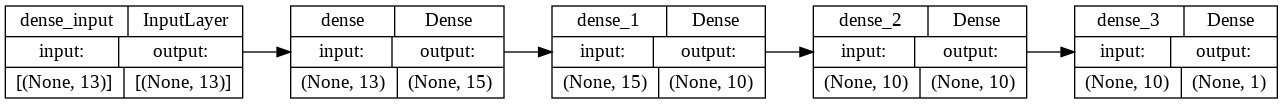

In [ ]:
keras.utils.plot_model(ann_clf, show_shapes=True, rankdir="LR")

In [ ]:
_, train_acc = ann_clf.evaluate(X_train, y_train, verbose=0)
_, val_acc = ann_clf.evaluate(X_val, y_val, verbose=0)
_, test_acc = ann_clf.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Validation: %.3f, Test: %.3f' % (train_acc, val_acc, test_acc))

ValueError: ignored

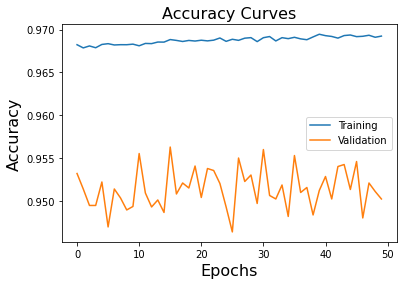

In [38]:
plt.plot(record.history['accuracy'], label='Training')
plt.plot(record.history['val_accuracy'], label='Validation')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)
plt.show()

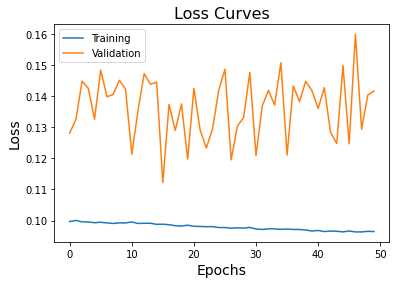

In [39]:
# plot training history
plt.plot(record.history['loss'], label='Training')
plt.plot(record.history['val_loss'], label='Validation')
plt.legend()
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss Curves', fontsize=16)
plt.show()

#### Experiment 2: Different Batch Sizes

In [ ]:
# Fit a Model and Plot Learning Curve

def fit_model_1(X_train, y_train, X_val, y_val, n_batch):
  
  # Define Model
  ann_clf = keras.models.Sequential([
      keras.layers.Dense(15, input_shape=(X_train.shape[1],), activation='relu'), # No bias term
      keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile Model
  ann_clf.compile(optimizer = 'adam', 
                  loss ='binary_crossentropy',
                  metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Recall()])

  
  # Fit Model
  history = ann_clf.fit(X_train,
                      y_train,
                      validation_data=(X_val, y_val),
                      epochs=100,
                      verbose=0,
                      batch_size=n_batch)

  # Plot Learning Curves
  plt.plot(history.history['accuracy'], label='train') 
  plt.plot(history.history['val_accuracy'], label='test') 
  plt.title('batch='+str(n_batch)) 
  plt.legend()

In [ ]:
# Create Learning Curves for Different Batch Sizes

# batch_sizes = [4, 6, 10, 16, 32, 64, 128, 260]
batch_sizes = [5, 10, 15, 20, 25, 30]

plt.figure(figsize=(10,15))
for i in range(len(batch_sizes)):

  # Determine the Plot Number
  plot_no = 420 + (i+1)
  plt.subplot(plot_no)

  # Fit Model and Plot Learning Curves for a Batch Size
  fit_model_1(X_train, y_train, X_val, y_val, batch_sizes[i])

plt.show()

#### Experiment 3: Different EPOCHs

In [ ]:
# Fit a Model and Plot Learning Curve

def fit_model_2(X_train, y_train, X_val, y_val, n_epoch):

  # Define Model
  ann_clf = keras.models.Sequential([
      keras.layers.Dense(15, input_shape=(X_train.shape[1],), activation='relu'), # No bias term
      keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile Model
  ann_clf.compile(optimizer = 'adam', 
                  loss ='binary_crossentropy',
                  metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Recall()])

    
  # Fit Model
  history = ann_clf.fit(X_train,
                      y_train,
                      validation_data=(X_val, y_val),
                      epochs=n_epoch,
                      verbose=0,
                      batch_size=6)
    
  # Plot Learning Curves
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.title('epoch='+str(n_epoch))
  plt.legend()

In [ ]:
# Create Learning Curves for Different EPOCHs

# epochs = [20, 50, 100, 120, 150, 200, 300, 400]
epochs = [20, 50, 80, 100, 150, 200]

plt.figure(figsize=(10,15))
for i in range(len(batch_sizes)):

  # Determine the Plot Number
  plot_no = 420 + (i+1)
  plt.subplot(plot_no)

  # Fit Model and Plot Learning Curves for an EPOCH
  fit_model_2(X_train, y_train, X_val, y_val, epochs[i])

plt.show()

#### Experiment 4: Early Stopping

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
def fit_model_3():

  # Define Model
  ann_clf = keras.models.Sequential([
      keras.layers.Dense(15, input_shape=(X_train.shape[1],), activation='relu'), # No bias term
      keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dense(10, activation='relu'), 
      keras.layers.Dropout(0.2),
      keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compile Model
  ann_clf.compile(optimizer = 'adam', 
                  loss ='binary_crossentropy',
                  metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Recall()])

  return ann_clf

ann_clf = fit_model_3()

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=150)

mc = ModelCheckpoint('best_model.h5',
                     monitor='val_accuracy',
                     mode='max',
                     verbose=1,
                     save_best_only=True)

history = ann_clf.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    verbose=0,
                    batch_size=25,
                    callbacks=[es, mc])

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Loss Curves', fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=[8,5])
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)

plt.show()

## Voting Classifier

- Library: Scikit-learn, Keras, Tensorflow
- Shuffling does not affect the model building. No random_state.
- No need for RandomizedSearchCV since there is only 1 important parameter: voting

In [ ]:
# Re-Train top 3 models using their best hyperparameters

model_1 = LGBMClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=10)
model_2 = GradientBoostingClassifier(n_estimators=500, learning_rate=0.5, max_depth=1, random_state=10)
model_3 = RandomForestClassifier(n_estimators=1000, max_depth = None, n_jobs =-1, random_state=10)

name = 'ensem_clf'

train = pd.DataFrame(columns = ['voting', 'n_jobs'])
train = train.append({'voting': 'hard', 'n_jobs': -1}, ignore_index=True)
train = train.append({'voting': 'soft', 'n_jobs': -1}, ignore_index=True)
train = train.reset_index()

for index, row in train.iterrows():
    model_name = name + str(index)
    ens_clf = VotingClassifier(estimators=[('m1', model_1), ('m2', model_2), ('m3', model_3)],
                               voting = row['voting'],
                               n_jobs = int(row['n_jobs']))
    ens_clf.fit(X_train, y_train)
    y_true = y_val
    y_pred = ens_clf.predict(X_val)
    evaluation_results = evaluation_metrics(y_true, y_pred)

    models = models.append({'model_name': model_name, 
                            'model': ens_clf, 
                            'parameters': ens_clf.get_params()}, 
                            ignore_index=True)
    
    models_eval = models_eval.append({'model_name': model_name, 
                                      'confusion_matrix' : evaluation_results[0], 
                                      'accuracy': evaluation_results[1], 
                                      'recall' : evaluation_results[2], 
                                      'f1_score': evaluation_results[3], 
                                      'roc_auc_score': evaluation_results[4]}, 
                                      ignore_index=True)

# Model Training Result

Best Hyperparameters for each model:

log_clf:

{'warm_start': True,
 'solver': 'lbfgs',
 'penalty': 'none',
 'max_iter': 331,
 'dual': False,
 'C': 0}

svm_clf:

{'kernel': 'rbf','C' : '8','class_weight'='balanced'}

bayes_clf:

{'var_smoothing': '1e-3'}

knn_clf:

{'n_neighbors': 19, 'algorithm': 'kd_tree'}

tree_clf:

{'splitter': 'random',
 'min_samples_leaf': 2,
 'max_features': 11,
 'max_depth': None,
 'criterion': 'entropy'}

rnd_clf:

{'n_estimators': 415,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 4,
 'max_depth': 18}

gboost_clf:

{'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.1}

xgboost_clf:

{'n_estimators': 1000,
 'min_child_weight': 7,
 'max_depth': 8,
 'learning_rate': 0.1}

lightgbm_clf:

{'num_leaves': 50,
 'n_estimators': 1000,
 'min_data_in_leaf': 10,
 'max_depth': 8,
 'learning_rate': 0.05}

ann_clf:

